In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from pylab import rcParams

sns.set(style='whitegrid', palette='muted', font_scale=1.5)
%config InlineBackend.figure_format='retina'
rcParams['figure.figsize'] = 16,10

raw = pd.read_csv('DailyDelhiClimateTrain.csv', index_col=False)

raw.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


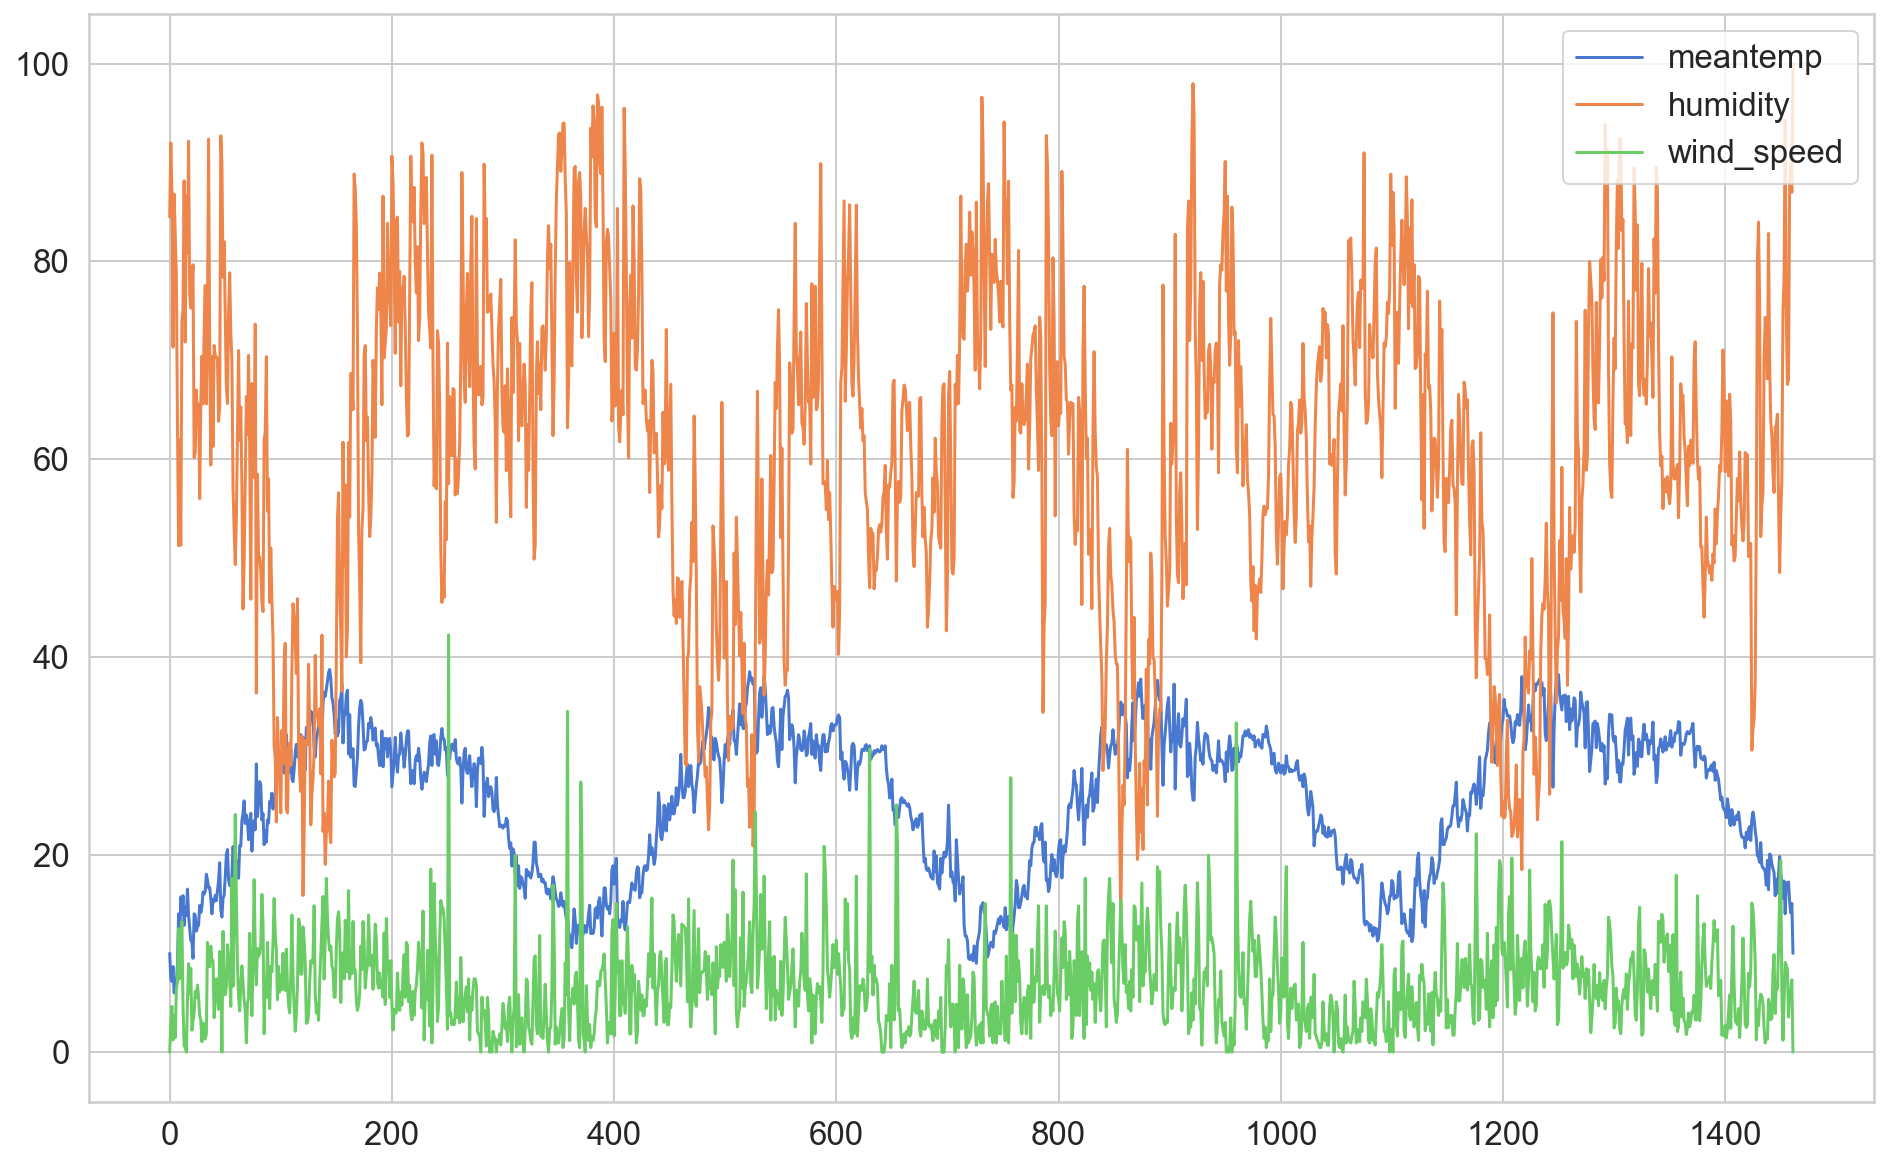

In [2]:
plots = ['meantemp','humidity','wind_speed']
for plot in plots:
    plt.plot(raw[plot], label = plot)
    plt.legend(loc = 'upper right')

let's predict these three as they seem to be interesting and periodical. We'll keep daily time steps.

In [3]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB


In [4]:
raw['date'] = pd.to_datetime(raw['date'])

In [5]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1462 non-null   datetime64[ns]
 1   meantemp      1462 non-null   float64       
 2   humidity      1462 non-null   float64       
 3   wind_speed    1462 non-null   float64       
 4   meanpressure  1462 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 57.2 KB


In [6]:
meantemp = raw[['date','meantemp']]
humidity = raw[['date','humidity']]
windspeed = raw[['date', 'wind_speed']]

to_reset = [meantemp, humidity, windspeed]
#let's make date as index for the purpose of dimensionality of the input data
for df in to_reset:
    df.set_index('date', inplace=True)

### MEANTEMP

In [7]:
train_size = int(len(meantemp)*0.8)
test_size = len(meantemp) - train_size

train1, test1 = meantemp.iloc[:train_size], meantemp.iloc[train_size:]
print(len(train1),len(test1))

1169 293


In [8]:
def create_dataset(X, y, time_steps = 1):
    Xs, ys = [], []
    for i in range(len(X)-time_steps): # rozsahu i minus (pocet elementu minus steps)
        v = X.iloc[i:(i+time_steps)].values #v je pro kazde i sekvence od i do i+steps
        Xs.append(v) #sekvence se pripoji do seznamu Xs
        ys.append(y.iloc[i+time_steps]) #y pro danou sekvenci se pripoji do ys
    return np.array(Xs), np.array(ys)

In [9]:
time_steps = 30

X_train, y_train = create_dataset(train1, train1.meantemp, time_steps)
X_test, y_test = create_dataset(test1, test1.meantemp, time_steps)

In [10]:
X_train.shape

(1139, 30, 1)

In [11]:
y_train.shape

(1139,)

In [12]:
X_train[0]

array([[10.        ],
       [ 7.4       ],
       [ 7.16666667],
       [ 8.66666667],
       [ 6.        ],
       [ 7.        ],
       [ 7.        ],
       [ 8.85714286],
       [14.        ],
       [11.        ],
       [15.71428571],
       [14.        ],
       [15.83333333],
       [12.83333333],
       [14.71428571],
       [13.83333333],
       [16.5       ],
       [13.83333333],
       [12.5       ],
       [11.28571429],
       [11.2       ],
       [ 9.5       ],
       [14.        ],
       [13.83333333],
       [12.25      ],
       [12.66666667],
       [12.85714286],
       [14.83333333],
       [14.125     ],
       [14.71428571]])

In [13]:
y_train[0]

16.2

In [14]:
#model
import tensorflow as tf
from tensorflow import keras

lr = 0.001

adam = keras.optimizers.Adam(lr)

model = keras.Sequential([
    keras.layers.LSTM(128, input_shape = (X_train.shape[1],X_train.shape[2]), return_sequences = True),
    keras.layers.LSTM(128),
    keras.layers.Dense(1)
])

model.compile(loss = 'mean_squared_error', optimizer = adam)

In [15]:
epochs = 50
batch_size = 16
validation_split = 0.1
patience = 5
ES = keras.callbacks.EarlyStopping(monitor='loss', patience=patience, restore_best_weights = True)

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose = 1,
         callbacks = [ES], shuffle = False)

Epoch 1/50
65/65 [==============================] - 5s 83ms/step - loss: 232.0177 - val_loss: 16.8623
Epoch 2/50
65/65 [==============================] - 4s 55ms/step - loss: 75.6613 - val_loss: 42.4816
Epoch 3/50
65/65 [==============================] - 3s 51ms/step - loss: 54.5259 - val_loss: 65.5716
Epoch 4/50
65/65 [==============================] - 4s 56ms/step - loss: 51.2611 - val_loss: 75.6988
Epoch 5/50
65/65 [==============================] - 3s 53ms/step - loss: 50.8339 - val_loss: 77.9748
Epoch 6/50
65/65 [==============================] - 4s 55ms/step - loss: 50.6415 - val_loss: 73.5934
Epoch 7/50
65/65 [==============================] - 3s 47ms/step - loss: 46.3433 - val_loss: 34.7007
Epoch 8/50
65/65 [==============================] - 4s 55ms/step - loss: 24.1855 - val_loss: 10.6119
Epoch 9/50
65/65 [==============================] - 4s 54ms/step - loss: 16.8997 - val_loss: 31.0223
Epoch 10/50
65/65 [==============================] - 3s 52ms/step - loss: 10.4468 - val_lo

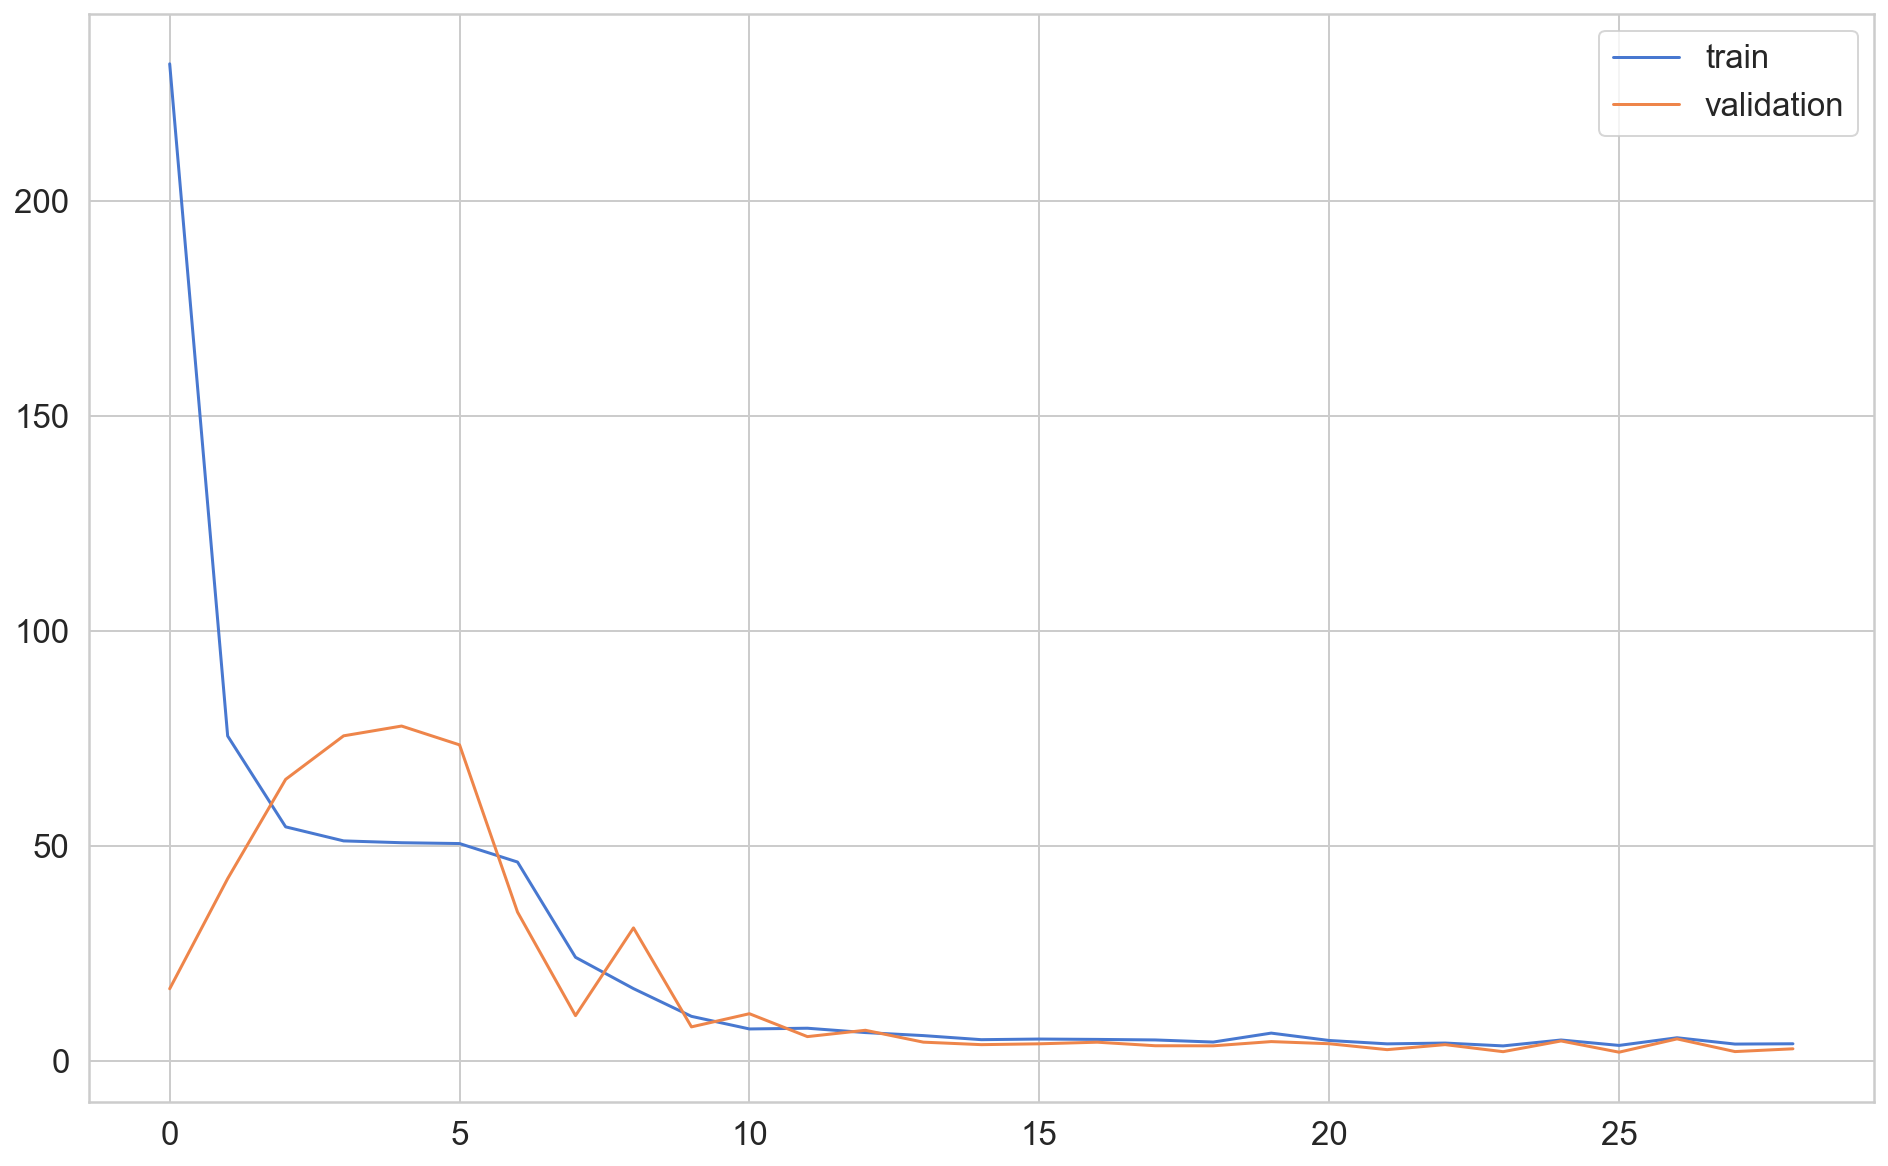

In [16]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'validation')
plt.legend()

In [17]:
y_pred = model.predict(X_test)

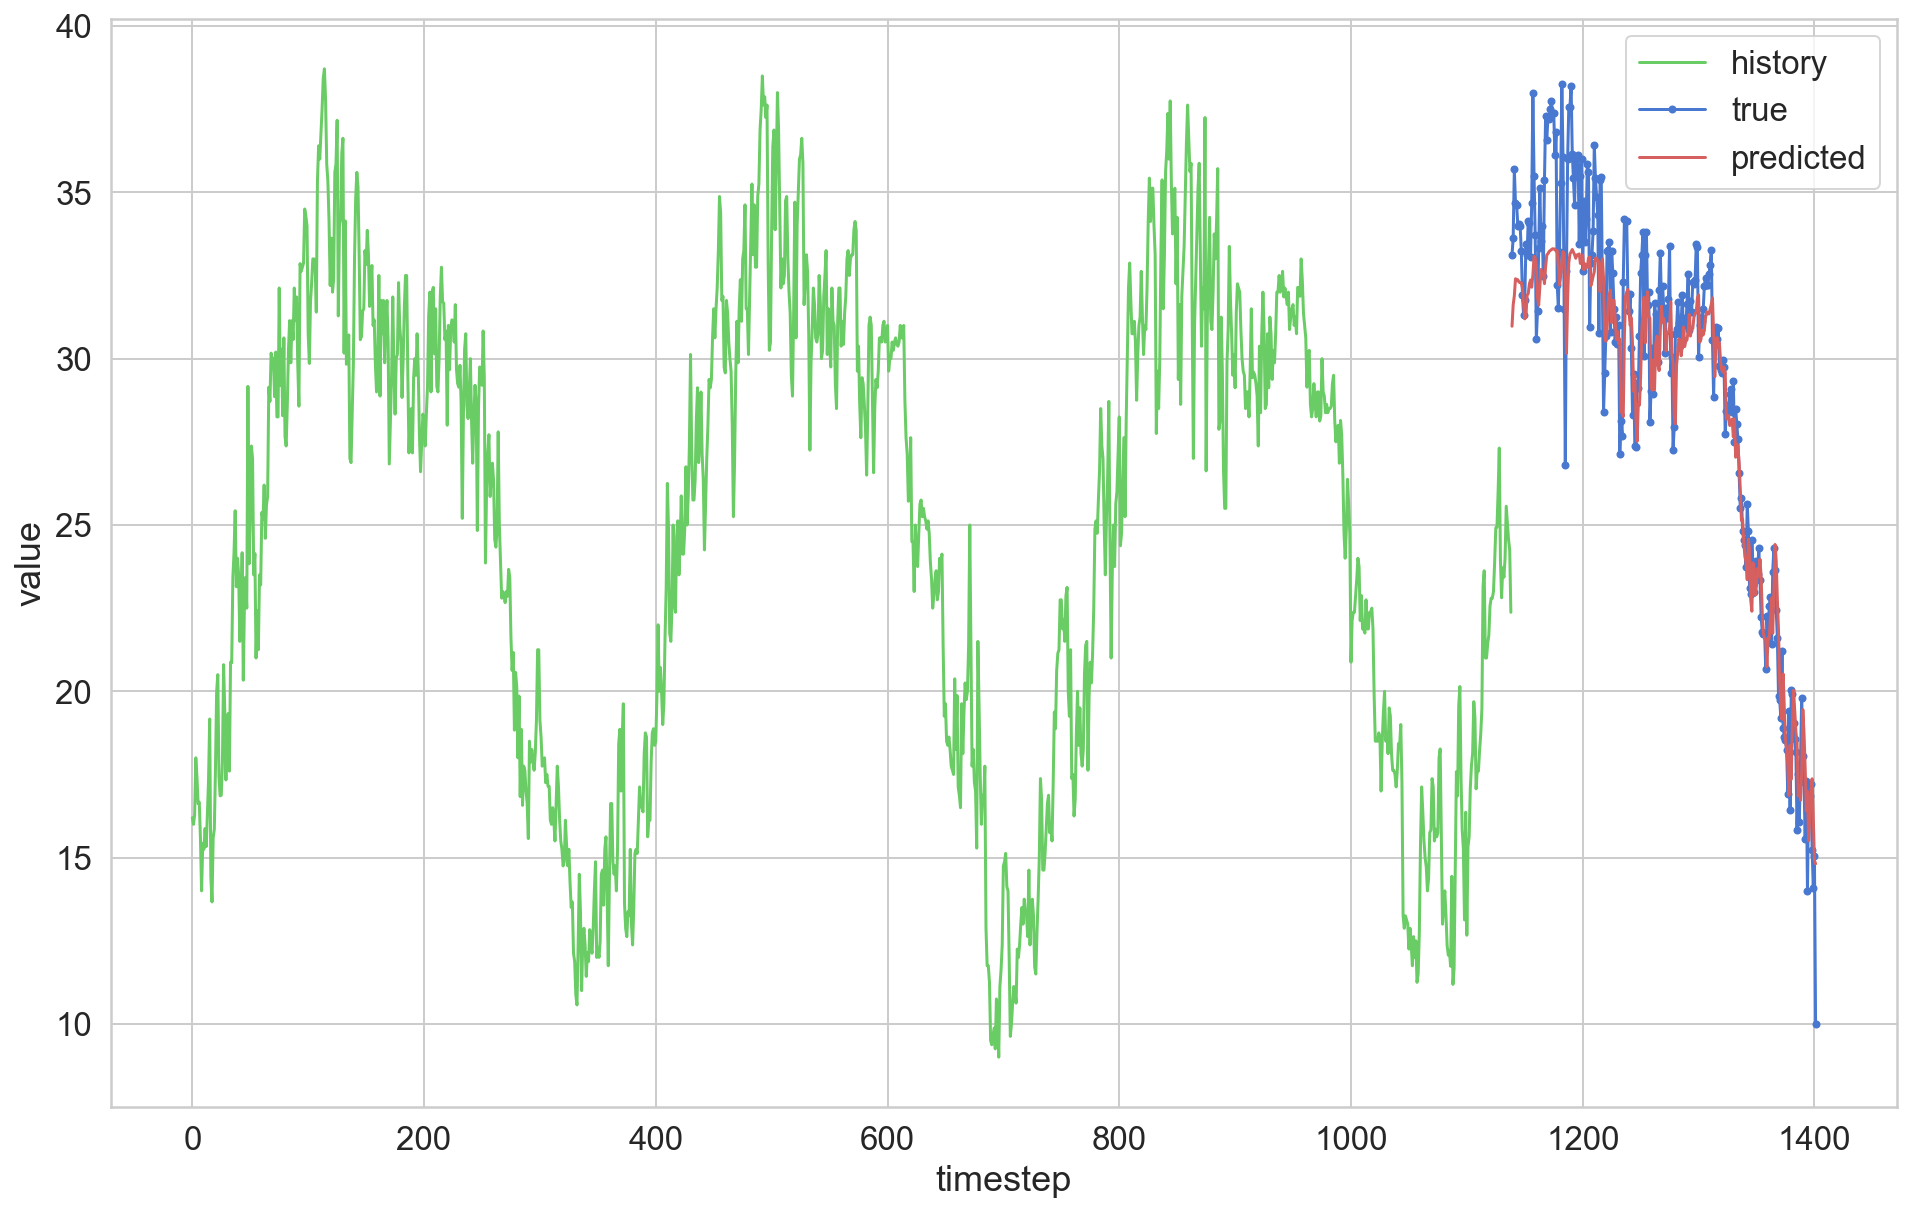

In [18]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label='history')
plt.plot(np.arange(len(y_train), len(y_train)+len(y_test)), y_test, marker = '.', label = 'true')
plt.plot(np.arange(len(y_train), len(y_train)+len(y_test)), y_pred, 'r', label = 'predicted')
plt.xlabel('timestep')
plt.ylabel('value')
plt.legend()
plt.show()

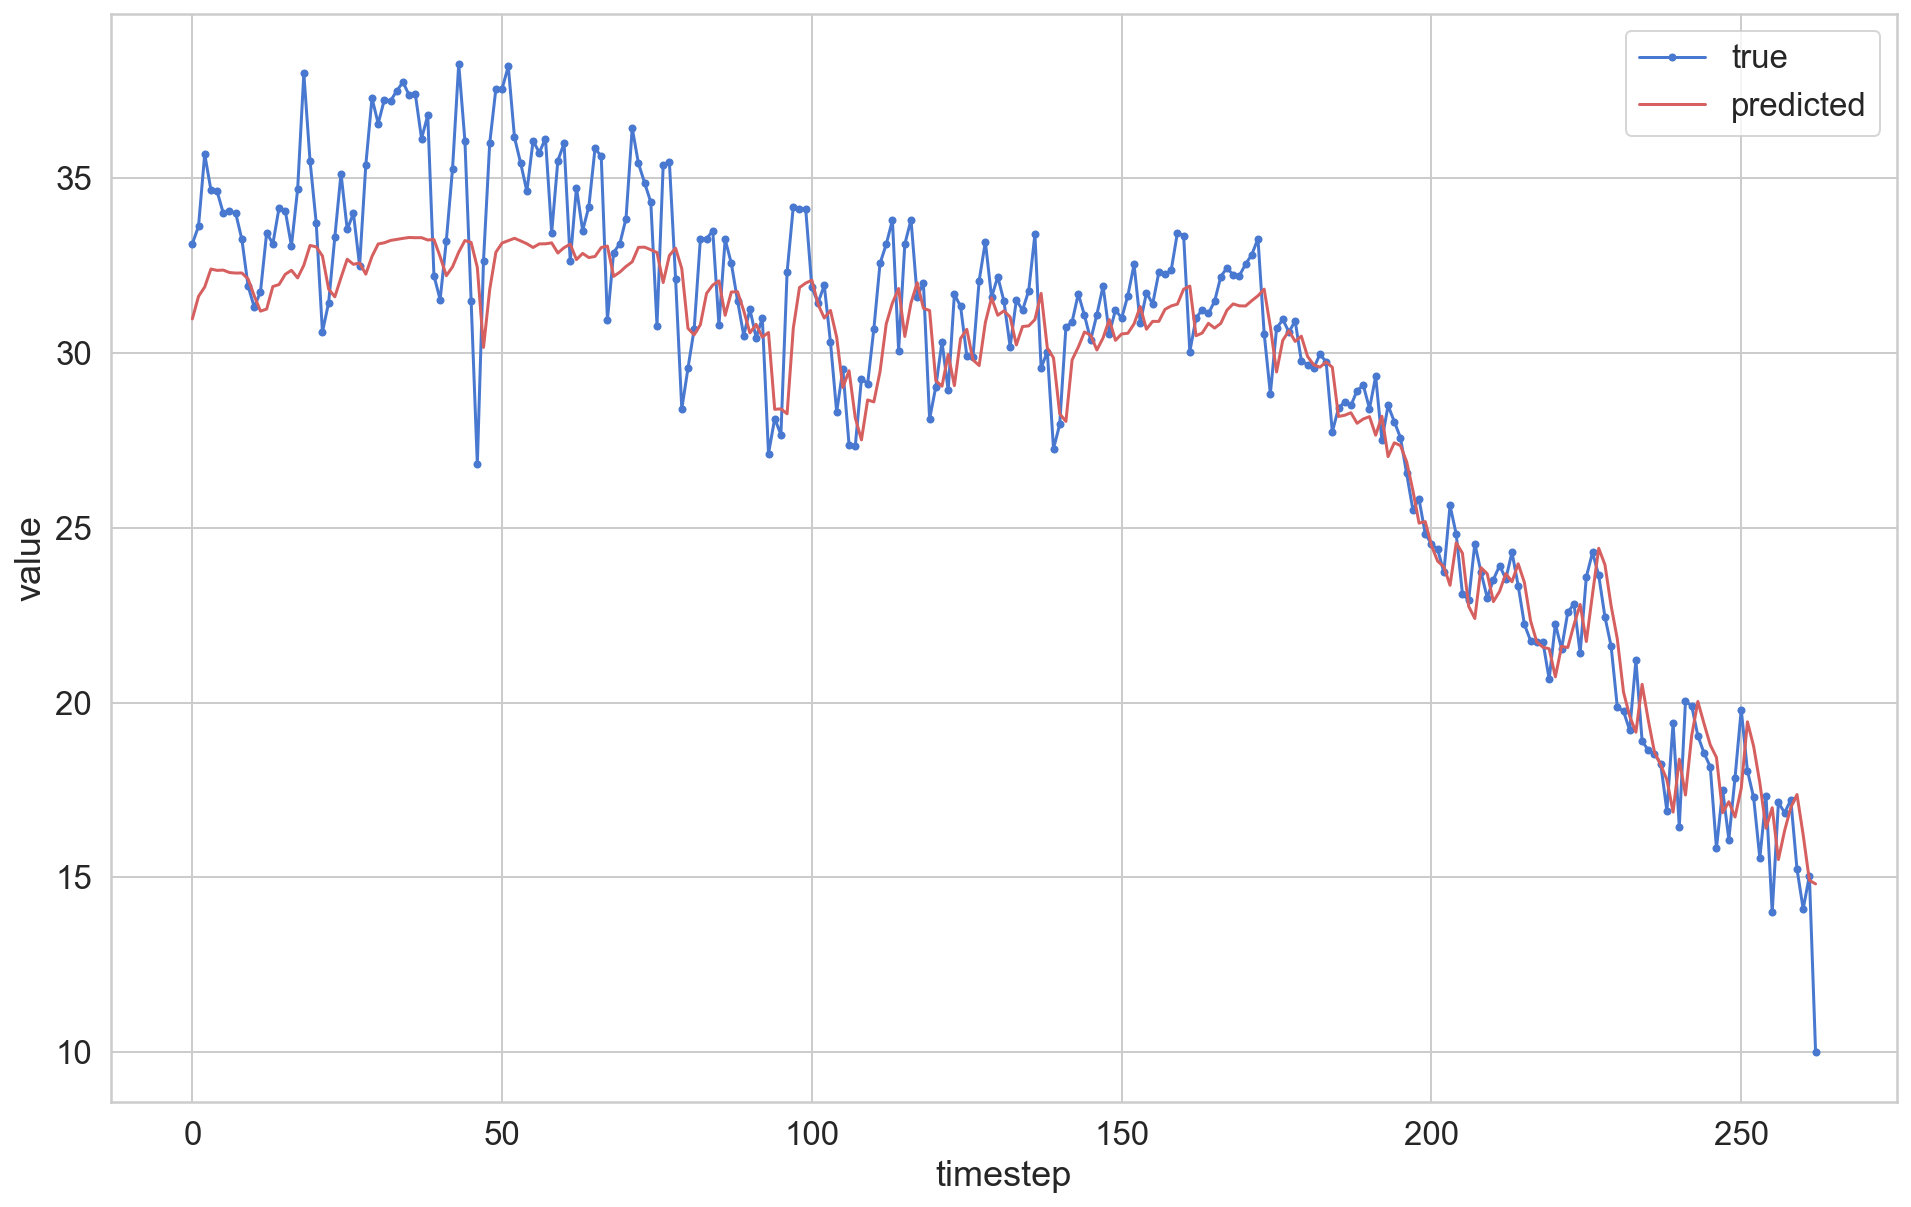

In [19]:
plt.plot(y_test, marker = '.', label = 'true' )
plt.plot(y_pred, 'r', label = 'predicted')
plt.xlabel('timestep')
plt.ylabel('value')
plt.legend()
plt.show()

In [30]:
raw['date'].head()

0   2013-01-01
1   2013-01-02
2   2013-01-03
3   2013-01-04
4   2013-01-05
Name: date, dtype: datetime64[ns]

In [38]:
len(raw)

1462

In [50]:
search = []
for i in range(len(raw)-1):
    val = (raw['date'][i+1]-raw['date'][i])
    search.append(val)
search = [i.days for i in search]

In [60]:
from collections import Counter
counter = Counter(search)
counter #so there's no missing value and there's a mistake in my code apparently

Counter({1: 1461})

Let's try another timestep value on the remaining features. Also let's make functions for the stuff.

In [61]:
def train_model(X_train, y_train, epochs=epochs, batch_size = batch_size, optimizer = adam, validation_split=validation_split,
               ):
    model = keras.Sequential([
        keras.layers.LSTM(128, input_shape = (X_train.shape[1],X_train.shape[2]), return_sequences = True),
        keras.layers.LSTM(128),
        keras.layers.Dense(1)
    ])

    model.compile(loss = 'mean_squared_error', optimizer = adam)

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose = 1,
         callbacks = [ES], shuffle = False)
    
    return history, model

In [66]:
def split(df):
    train_size = int(len(df)*0.8)
    test_size = len(df) - train_size

    train1, test1 = df.iloc[:train_size], df.iloc[train_size:]
    return train1, test1 

In [67]:
train2, test2 = split(humidity)

In [68]:
time_steps2 = 10

X_train2, y_train2 = create_dataset(train2, train2.humidity, time_steps2)
X_test2, y_test2 = create_dataset(test2, test2.humidity, time_steps2)

In [71]:
history2, model2 = train_model(X_train2, y_train2)

Epoch 1/50
66/66 [==============================] - 3s 47ms/step - loss: 1368.6449 - val_loss: 646.1066
Epoch 2/50
66/66 [==============================] - 1s 21ms/step - loss: 386.0798 - val_loss: 276.3382
Epoch 3/50
66/66 [==============================] - 1s 22ms/step - loss: 302.4559 - val_loss: 198.8615
Epoch 4/50
66/66 [==============================] - 1s 22ms/step - loss: 291.6899 - val_loss: 176.1100
Epoch 5/50
66/66 [==============================] - 1s 22ms/step - loss: 289.8785 - val_loss: 168.1880
Epoch 6/50
66/66 [==============================] - 2s 23ms/step - loss: 289.4335 - val_loss: 165.1607
Epoch 7/50
66/66 [==============================] - 1s 22ms/step - loss: 289.2527 - val_loss: 163.9326
Epoch 8/50
66/66 [==============================] - 1s 22ms/step - loss: 289.1427 - val_loss: 163.4098
Epoch 9/50
66/66 [==============================] - 1s 22ms/step - loss: 289.0603 - val_loss: 163.1743
Epoch 10/50
66/66 [==============================] - 1s 22ms/step - loss

In [72]:
def plot_all(y_train, y_test, y_pred):
    plt.plot(np.arange(0, len(y_train)), y_train, 'g', label='history')
    plt.plot(np.arange(len(y_train), len(y_train)+len(y_test)), y_test, marker = '.', label = 'true')
    plt.plot(np.arange(len(y_train), len(y_train)+len(y_test)), y_pred, 'r', label = 'predicted')
    plt.xlabel('timestep')
    plt.ylabel('value')
    plt.legend()
    plt.show()

def plot_detail(y_test, y_pred): 
    plt.plot(y_test, marker = '.', label = 'true' )
    plt.plot(y_pred, 'r', label = 'predicted')
    plt.xlabel('timestep')
    plt.ylabel('value')
    plt.legend()
    plt.show()

In [74]:
y_pred2 = model2.predict(X_test2)

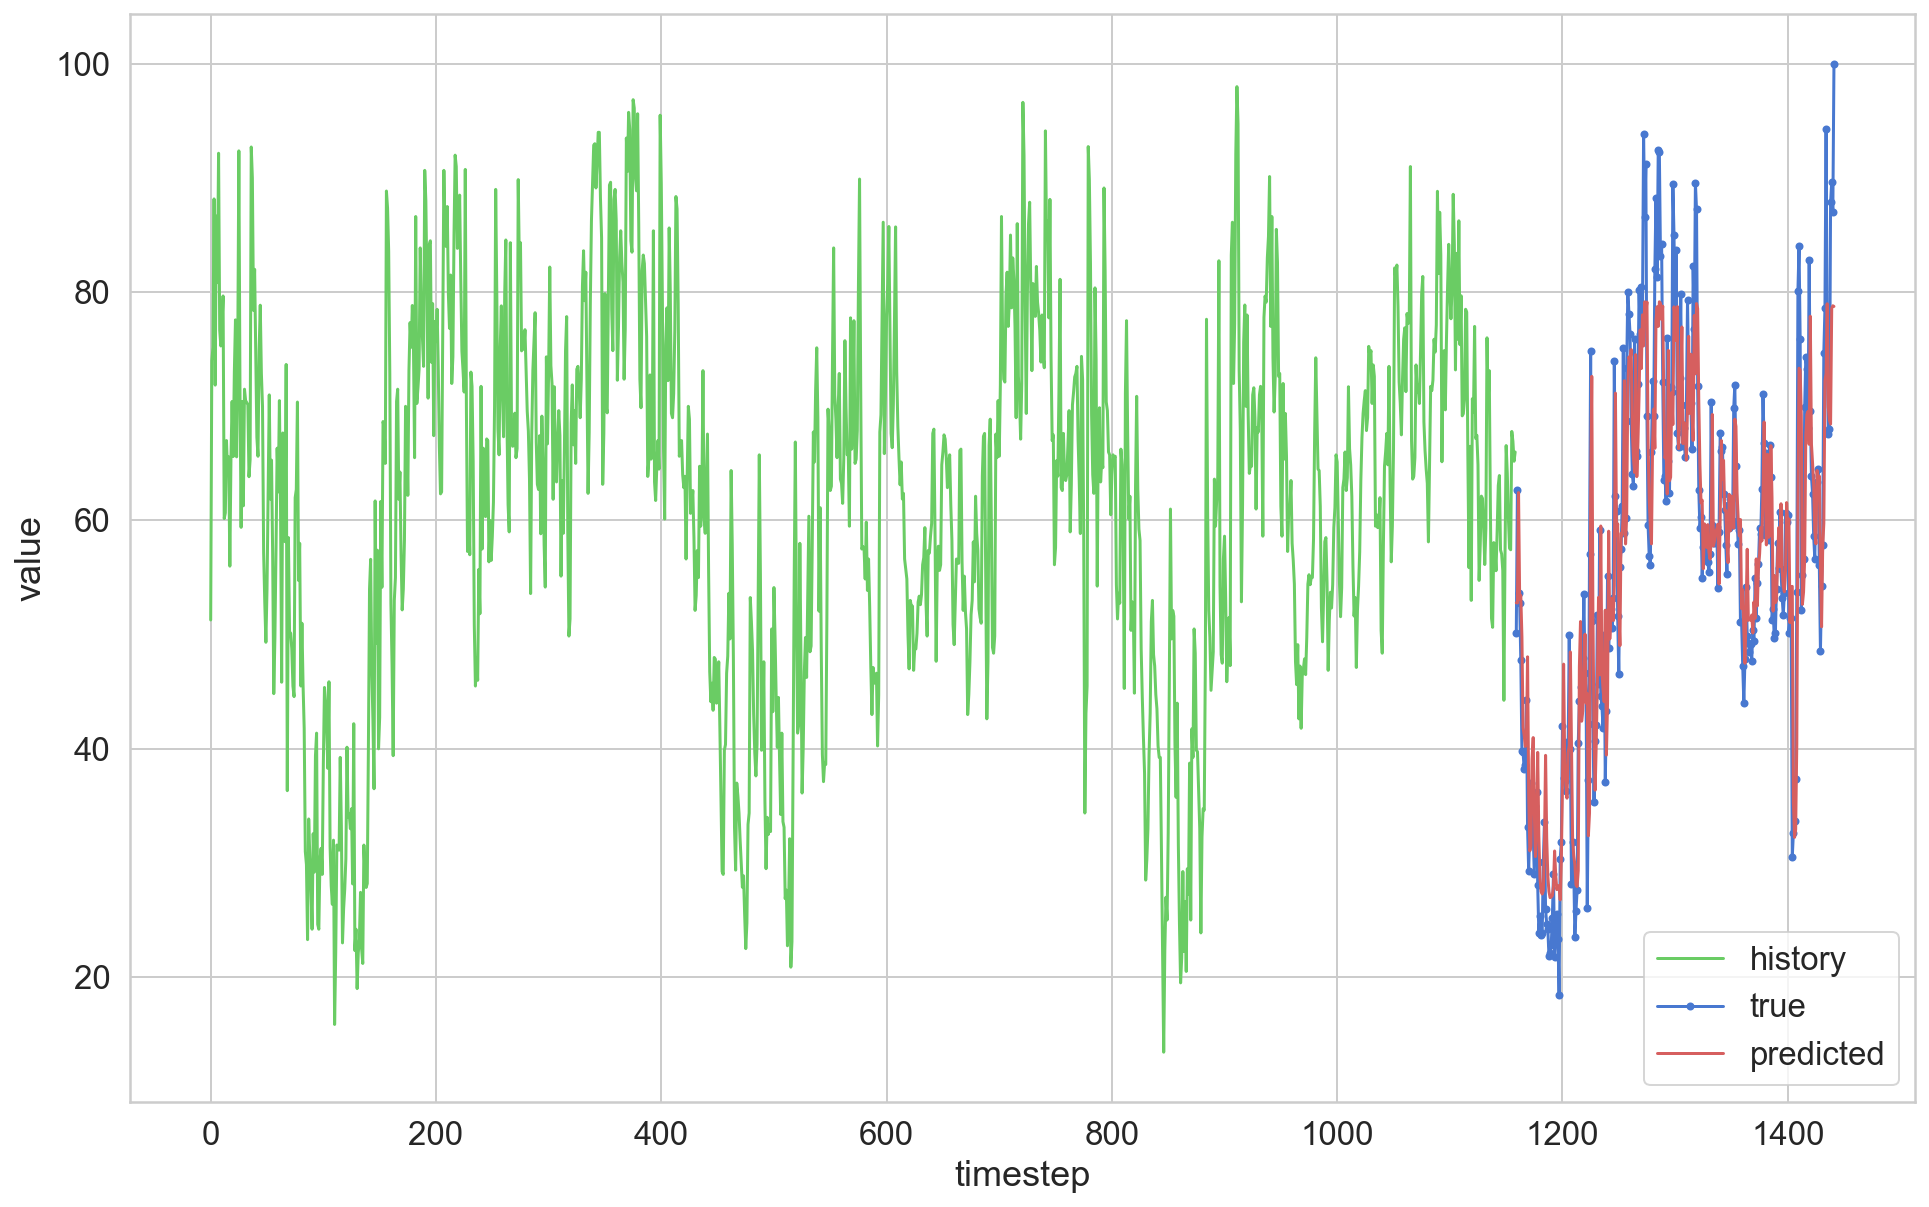

In [75]:
plot_all(y_train2, y_test2, y_pred2)

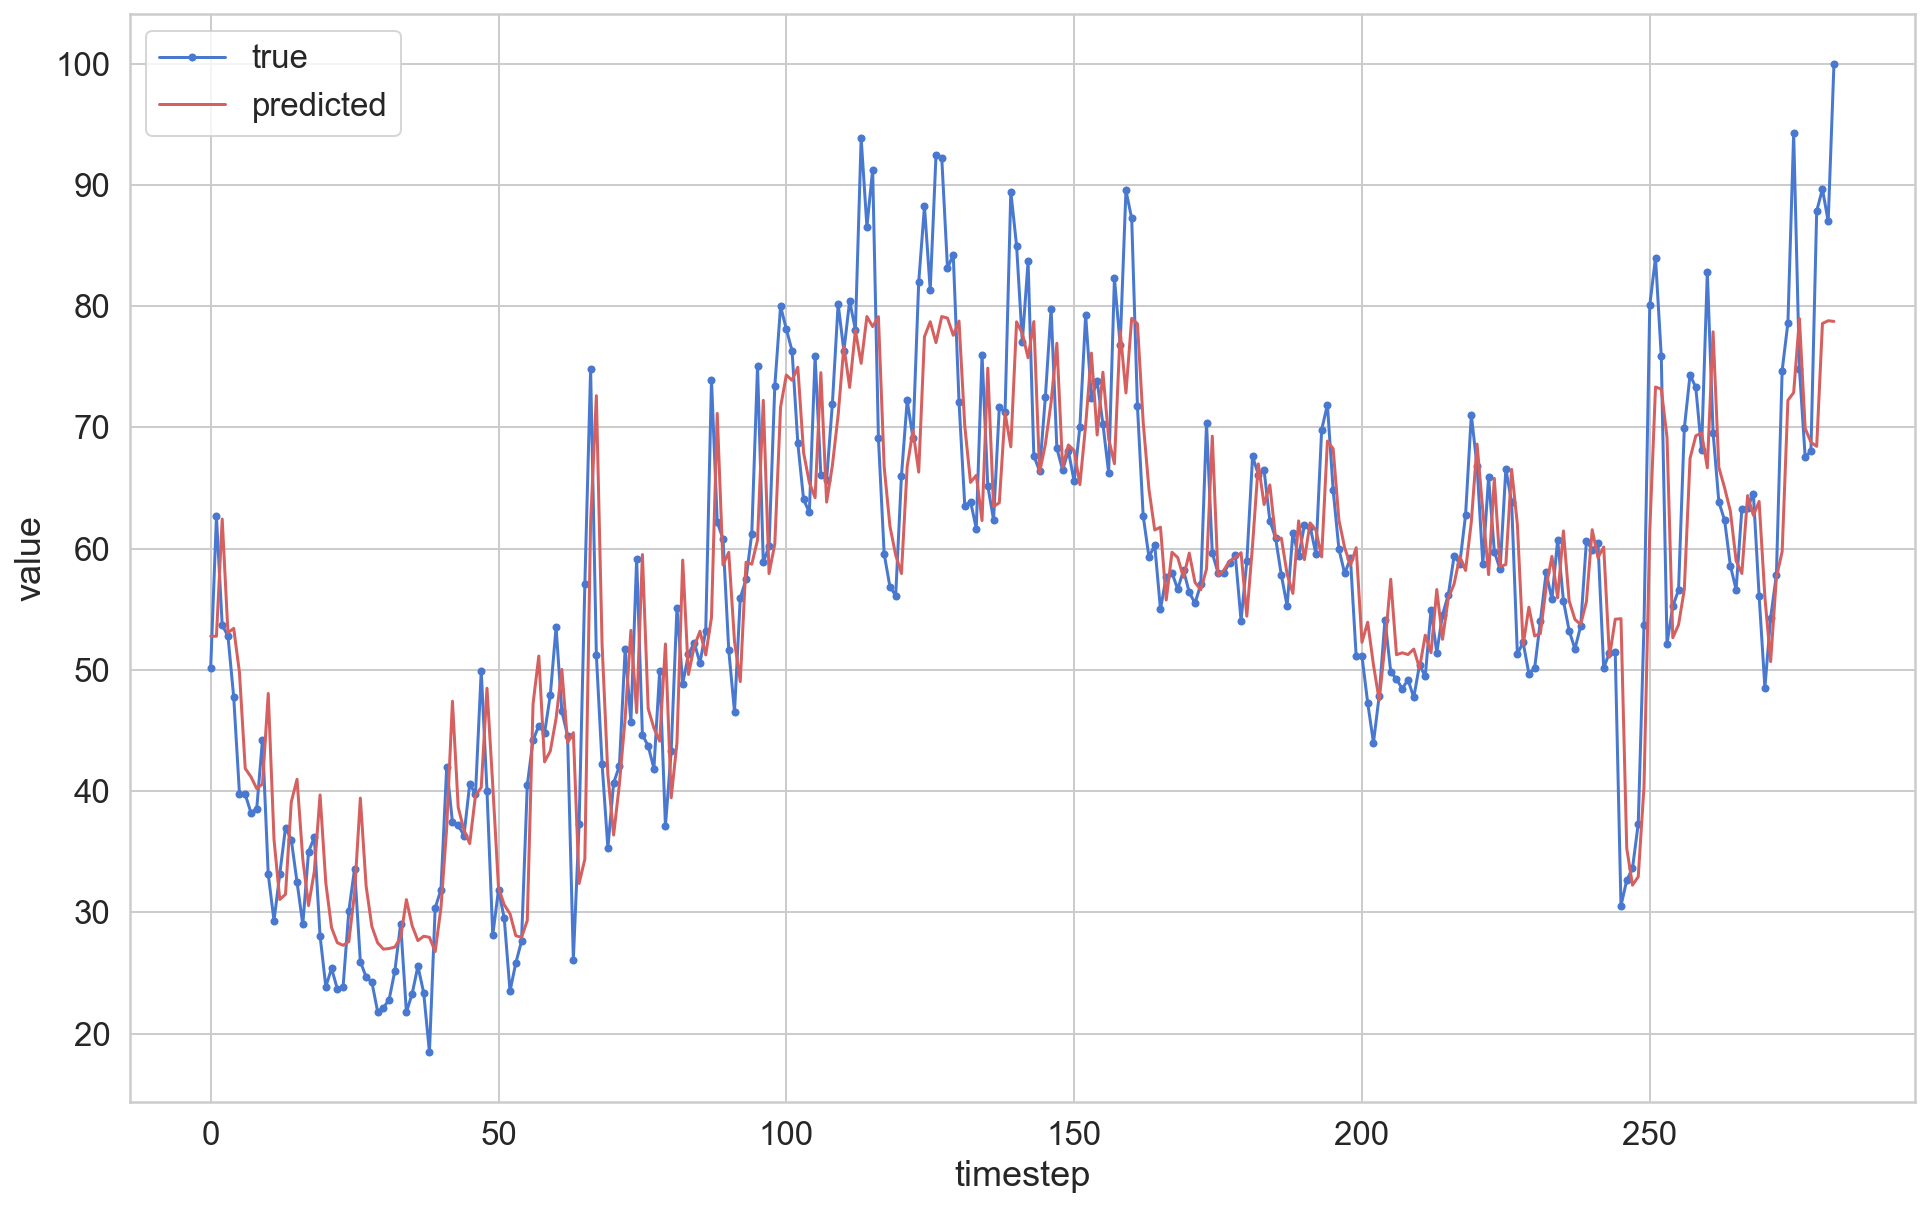

In [76]:
plot_detail(y_test2, y_pred2)

Let's try the same with the last data left, this looks nice actually

In [77]:
train3, test3 = split(windspeed)
time_steps3 = 15
X_train3, y_train3 = create_dataset(train3, train3['wind_speed'], time_steps3)
X_test3, y_test3 = create_dataset(test3, test3['wind_speed'], time_steps3)

In [78]:
history3, model3 = train_model(X_train3, y_train3)

Epoch 1/50
65/65 [==============================] - 3s 51ms/step - loss: 25.1215 - val_loss: 16.0871
Epoch 2/50
65/65 [==============================] - 2s 31ms/step - loss: 23.1574 - val_loss: 15.6223
Epoch 3/50
65/65 [==============================] - 2s 31ms/step - loss: 23.0114 - val_loss: 15.5588
Epoch 4/50
65/65 [==============================] - 2s 31ms/step - loss: 22.9311 - val_loss: 15.5437
Epoch 5/50
65/65 [==============================] - 2s 31ms/step - loss: 22.8734 - val_loss: 15.5370
Epoch 6/50
65/65 [==============================] - 2s 30ms/step - loss: 22.8237 - val_loss: 15.4953
Epoch 7/50
65/65 [==============================] - 2s 31ms/step - loss: 22.7614 - val_loss: 15.4272
Epoch 8/50
65/65 [==============================] - 2s 31ms/step - loss: 22.5384 - val_loss: 15.3060
Epoch 9/50
65/65 [==============================] - 2s 31ms/step - loss: 21.3595 - val_loss: 13.5302
Epoch 10/50
65/65 [==============================] - 2s 30ms/step - loss: 19.8175 - val_los

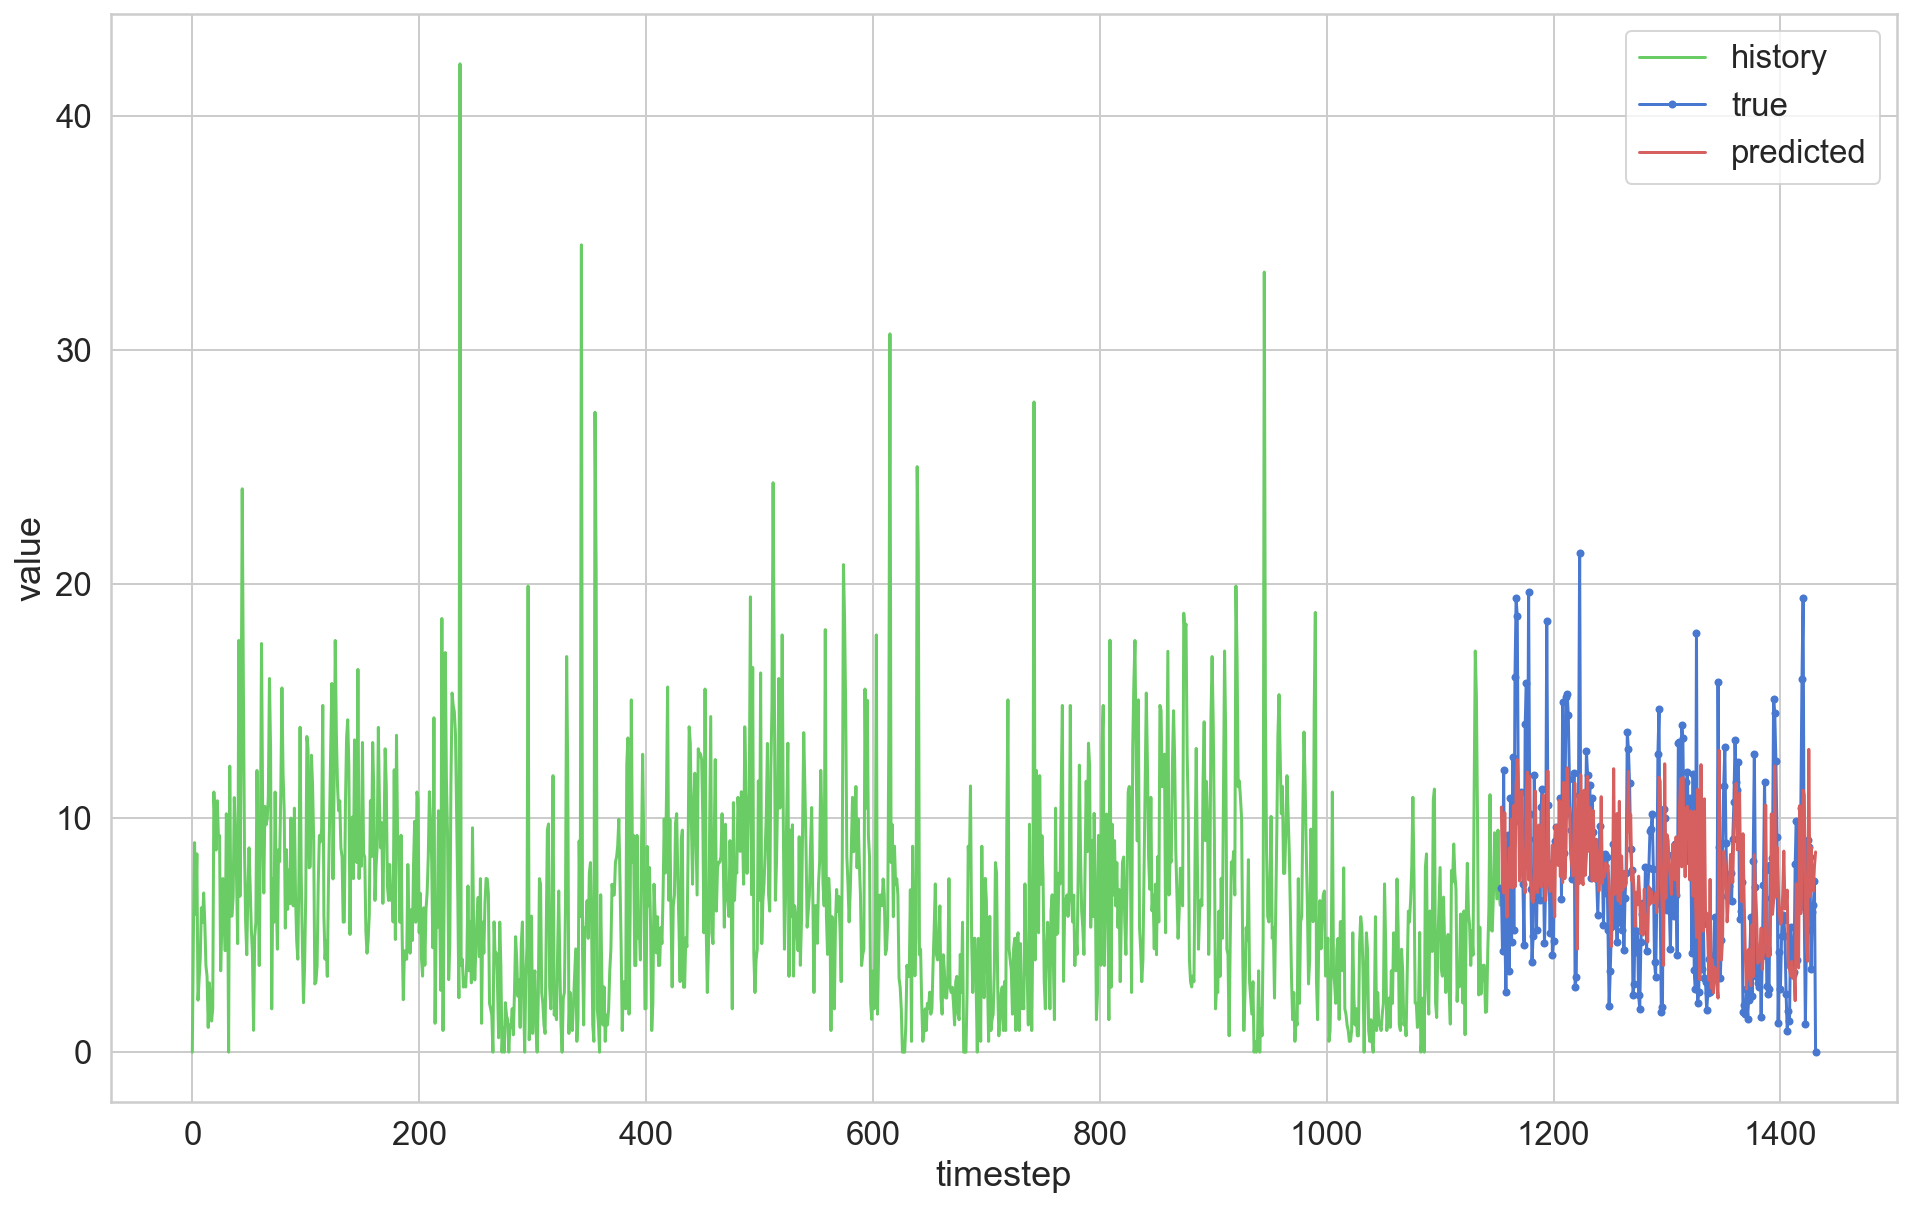

In [80]:
y_pred3 = model3.predict(X_test3)

plot_all(y_train3, y_test3, y_pred3)

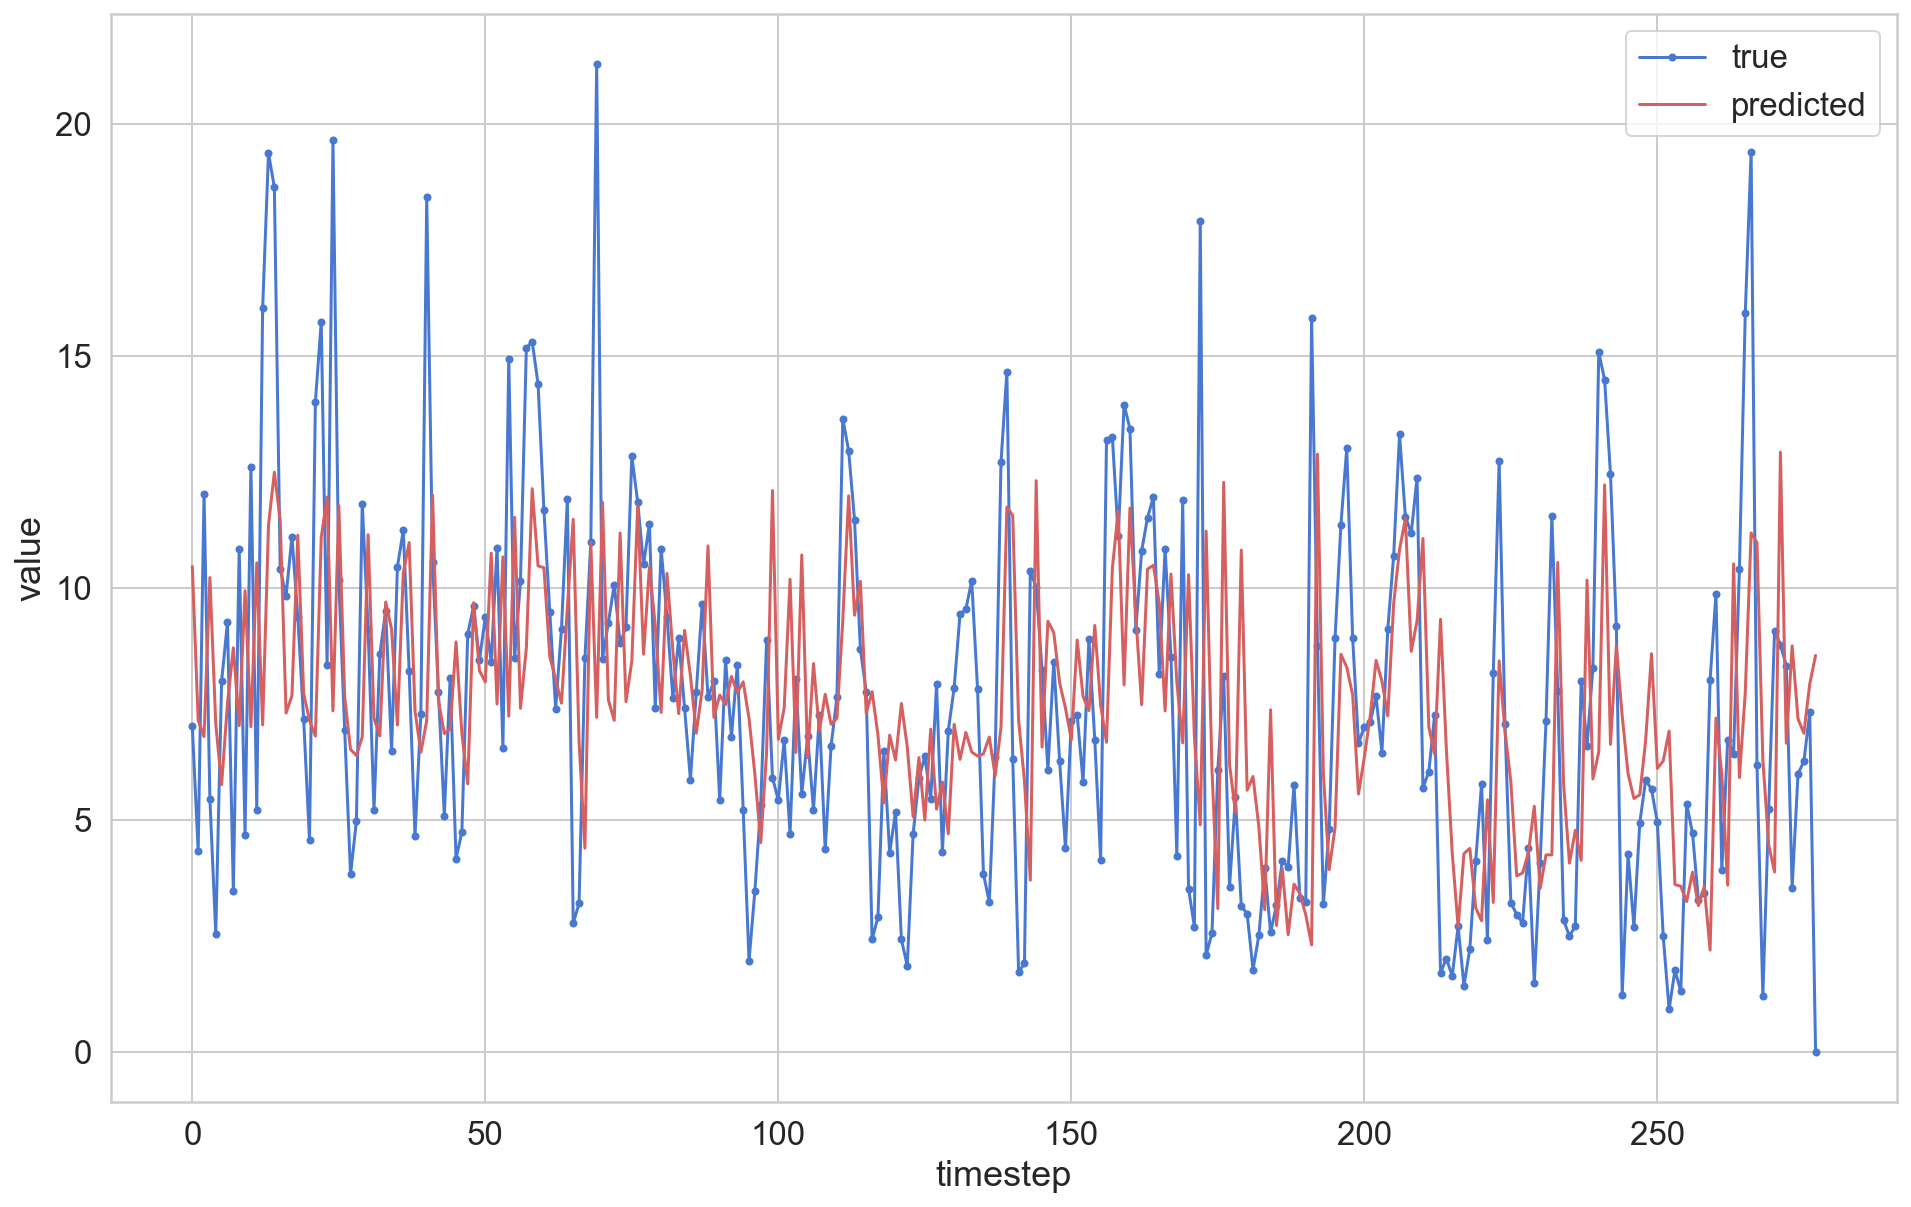

In [81]:
plot_detail(y_test3, y_pred3)

The models seem to be generalizing well, although there's plenty to improve, especially while building a comprehensive complex solution using functions, there's room to make the code better. 

Not bad for a saturday morning project though.

NOTE: the last one overfit a little?

anyway, the final step is trying the models on the test data.

In [82]:
rawtest = pd.read_csv('DailyDelhiClimateTest.csv')

rawtest.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333


In [83]:
temp_test = rawtest[['date','meantemp']]
humidity_test = rawtest[['date','humidity']]
windspeed_test = rawtest[['date', 'wind_speed']]

to_reset = [temp_test, humidity_test, windspeed_test]
#let's make date as index for the purpose of dimensionality of the input data
for df in to_reset:
    df.set_index('date', inplace=True)

In [86]:
X_temp, y_temp = create_dataset(temp_test, temp_test.meantemp, 30) # we trained this one with 30 days sequences

In [87]:
temp_pred = model.predict(X_temp)

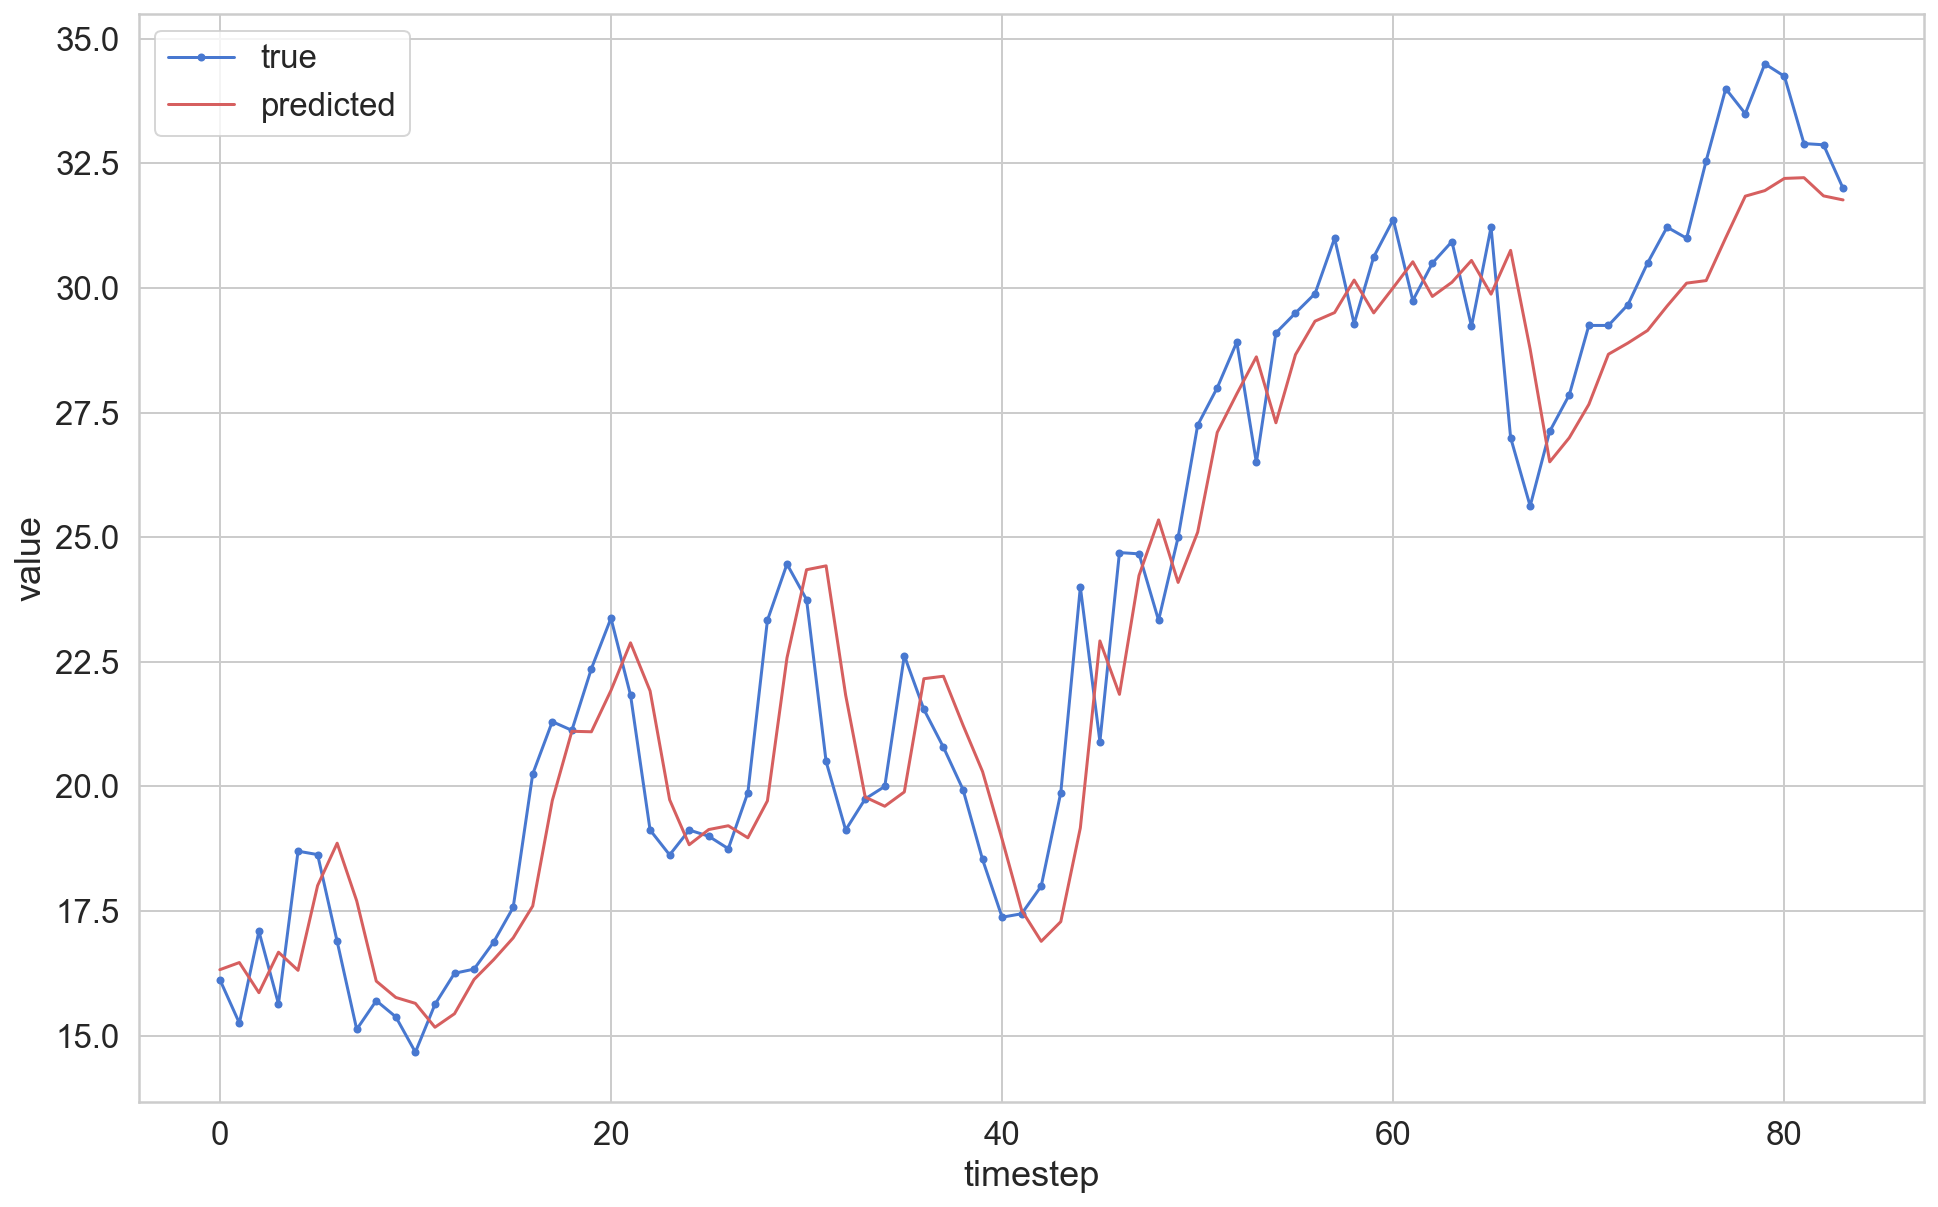

In [89]:
plot_detail(y_temp, temp_pred)

Is there a mistake in sequencing that caused the first graph to have a gap...?

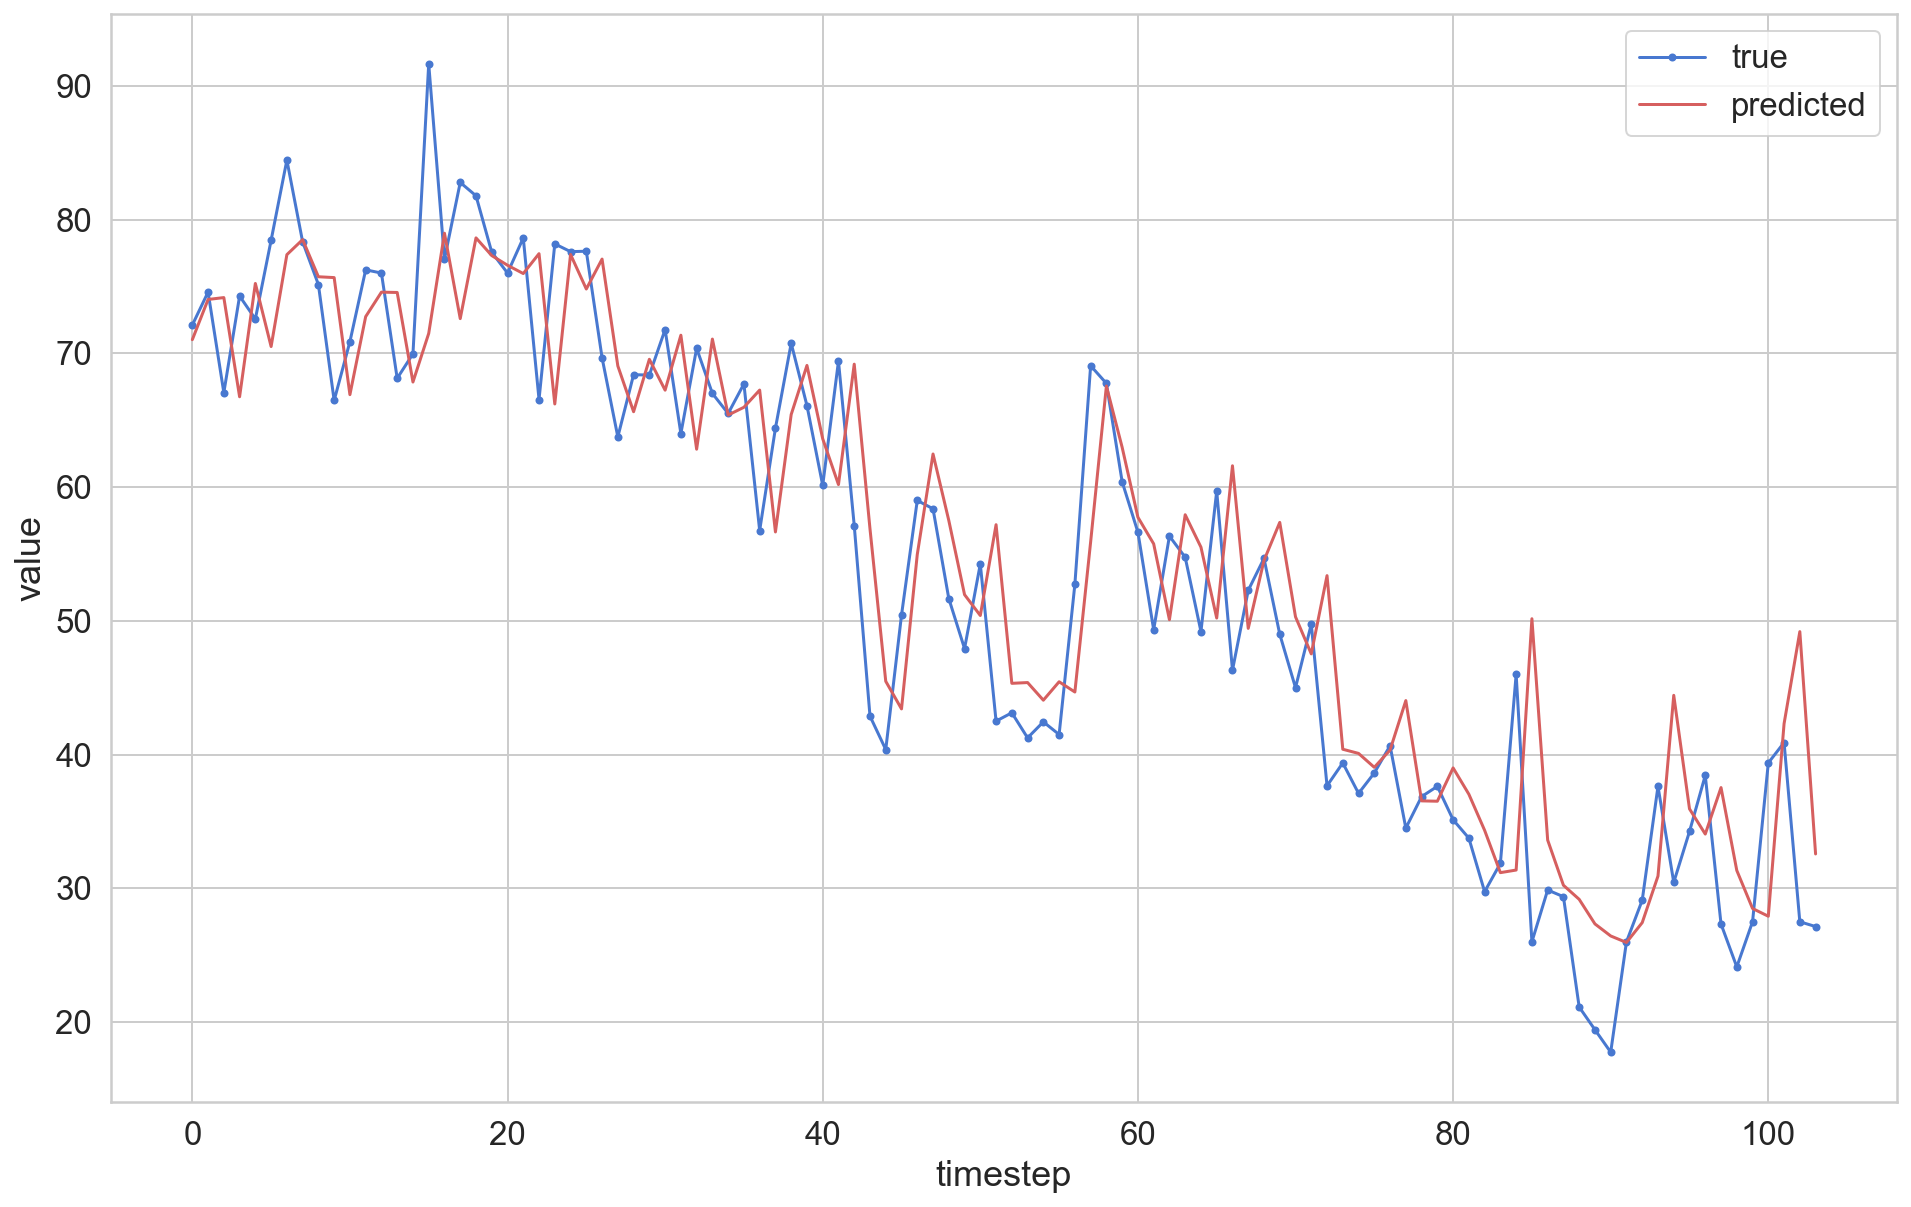

In [90]:
X_humidity, y_humidity = create_dataset(humidity_test, humidity_test.humidity, time_steps2)
humidity_pred = model2.predict(X_humidity)
plot_detail(y_humidity, humidity_pred)

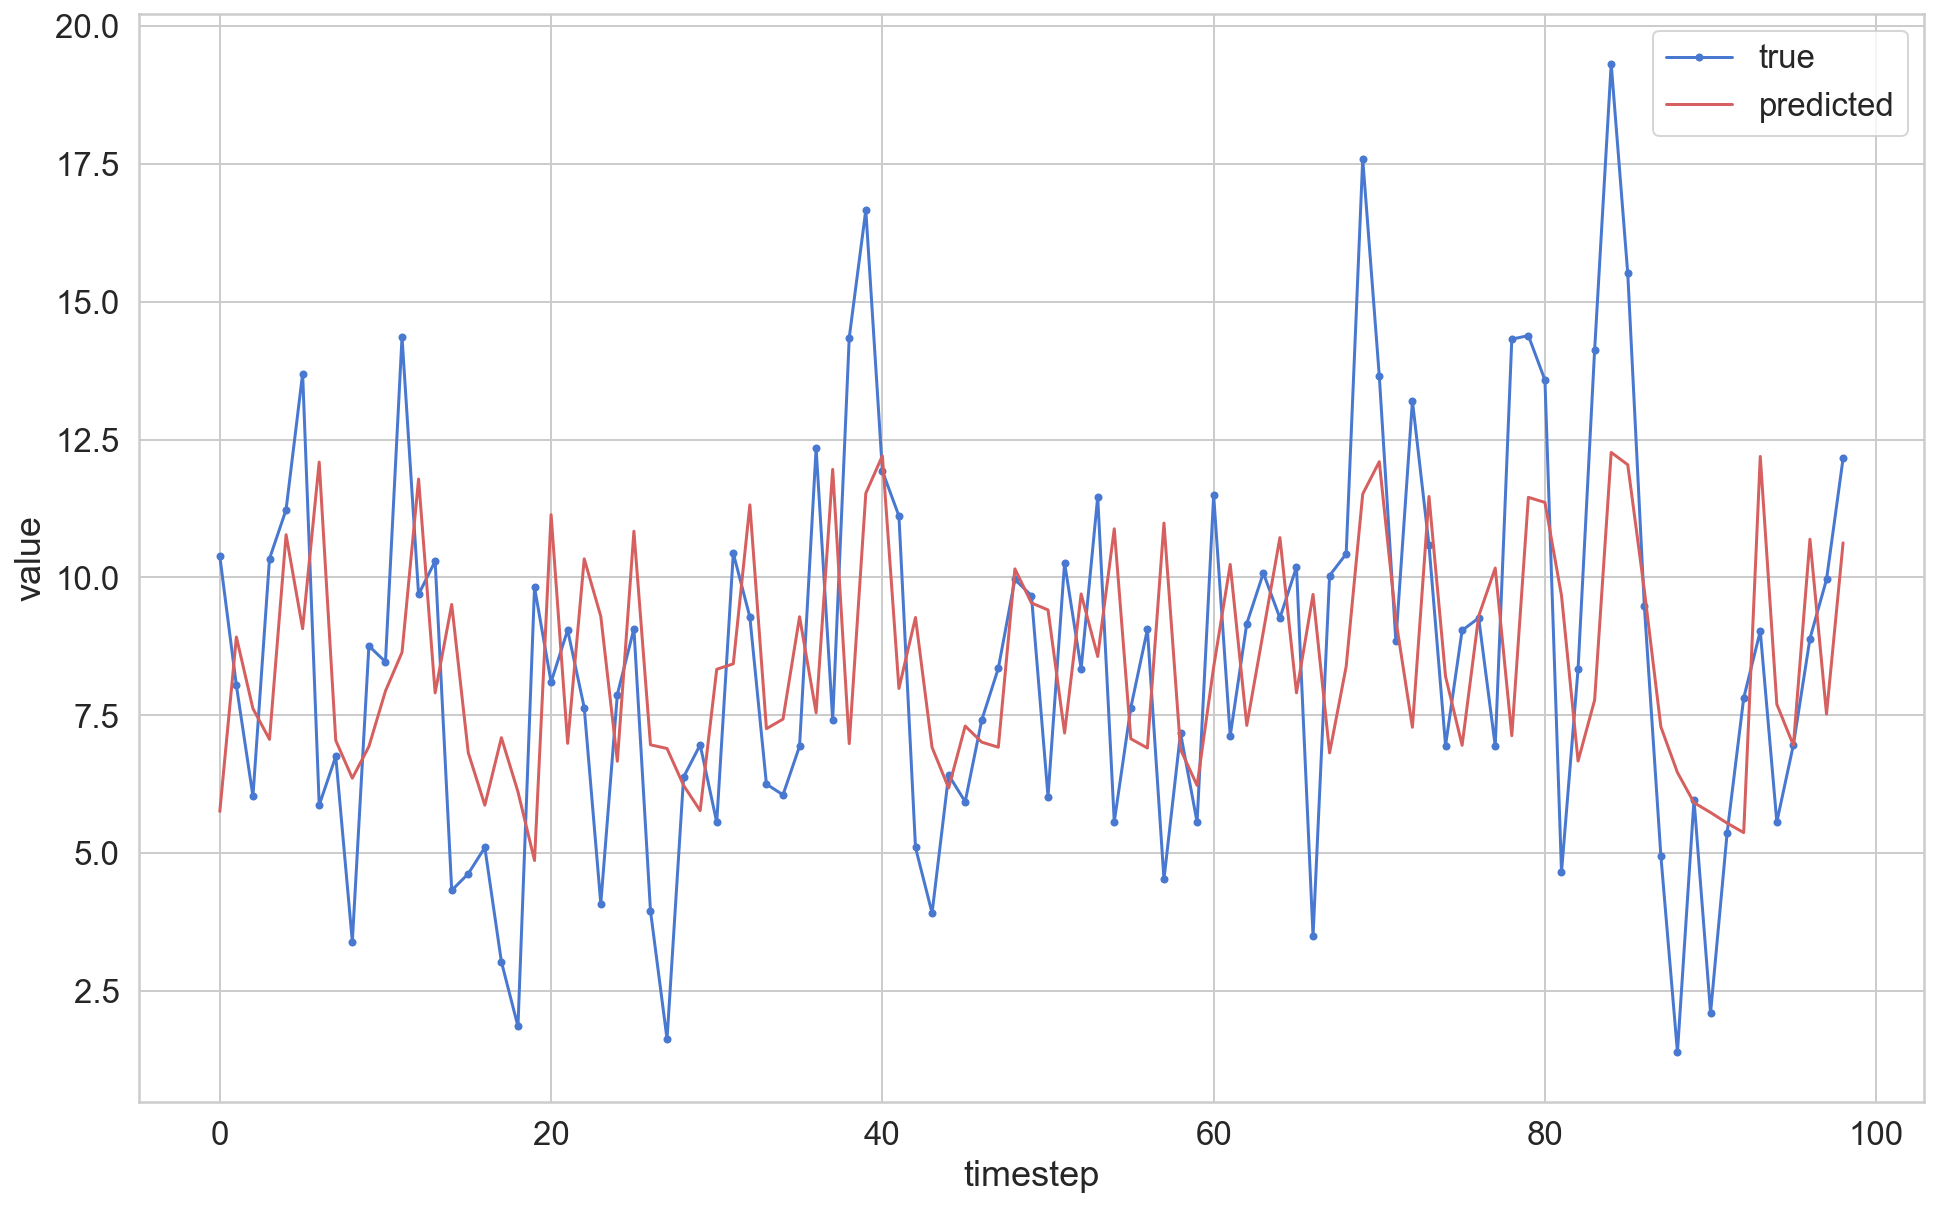

In [91]:
X_wind, y_wind = create_dataset(windspeed_test, windspeed_test['wind_speed'], time_steps3)
windspeed_pred = model3.predict(X_wind)
plot_detail(y_wind, windspeed_pred)

## CONCLUSION

This was my second LSTM project. I am not going to futher inspect possible mistake in sequencing, as I understand the concept and the method, need more theoretical knowledge on the process overall, though. Anyway, a good effort on creating functions instead of copying code over and over again, the models seem to be generalizing well (the third one needs some tuning though). This was fun.